### Dependencies

In [17]:
# Dependencies
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import exposure
import multiprocessing as mp
import albumentations as albu
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers, applications
from keras.models import Model, load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Required repositories
os.system('pip install segmentation-models')
os.system('pip install keras-rectified-adam')
os.system('pip install tta-wrapper')

from keras_radam import RAdam
import segmentation_models as sm
from tta_wrapper import tta_segmentation

# Misc
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)
    
    
# Segmentation related
def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def get_mask_area(df, index, column_name, shape=(1400, 2100)):
    rle = df.loc[index][column_name]
    try:
        math.isnan(rle)
        np_mask = np.zeros((shape[0], shape[1], 3))
    except:
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
        
    return int(np.sum(np_mask))

def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
# Data pre-process
def preprocess_image(image_id, base_path, save_path, HEIGHT, WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
        
# def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
#     df = df.reset_index()
#     for i in range(df.shape[0]):
#         item = df.iloc[i]
#         image_id = item['image']
#         item_set = item['set']
#         if item_set == 'train':
#             preprocess_image(image_id, train_base_path, train_images_dest_path, HEIGHT, WIDTH)
#         if item_set == 'validation':
#             preprocess_image(image_id, train_base_path, validation_images_dest_path, HEIGHT, WIDTH)
#         if item_set == 'test':
#             preprocess_image(image_id, test_base_path, test_images_dest_path, HEIGHT, WIDTH)

# Model evaluation
def get_metrics_classification(df, preds, label_columns, threshold=0.5, show_report=True):
  accuracy = []
  precision = []
  recall = []
  f_score = []
  for index, label in enumerate(label_columns):
    print('Metrics for: %s' % label)
    if show_report:
      print(classification_report(df[label], (preds[:,index] > threshold).astype(int), output_dict=False))
    metrics = classification_report(df[label], (preds[:,index] > threshold).astype(int), output_dict=True)
    accuracy.append(metrics['accuracy'])
    precision.append(metrics['1']['precision'])
    recall.append(metrics['1']['recall'])
    f_score.append(metrics['1']['f1-score'])
    
  print('Averaged accuracy:  %.2f' % np.mean(accuracy))
  print('Averaged precision: %.2f' % np.mean(precision))
  print('Averaged recall:    %.2f' % np.mean(recall))
  print('Averaged f_score:   %.2f' % np.mean(f_score))

def plot_metrics(history, metric_list=['loss', 'dice_coef'], figsize=(22, 14)):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(22, len(metric_list)*4))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best')
        axes[index].set_title(metric)

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()

# Model post process
def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

# Prediction evaluation
def get_metrics(model, target_df, df, df_images_dest_path, label_columns, tresholds, min_mask_sizes, N_CLASSES=4, seed=0, preprocessing=None, adjust_fn=None, adjust_param=None, set_name='Complete set', column_names=['Class', 'Dice', 'Dice Post']):
    metrics = []

    for class_name in label_columns:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)
    
    for i in range(0, df.shape[0], 500):
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=model.input_shape[1:3],
                      n_channels=model.input_shape[3],
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[1]] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[2]] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({column_names[0]:set_name, column_names[1]:np.mean(metrics_df[column_names[1]].values), column_names[2]:np.mean(metrics_df[column_names[2]].values)}, ignore_index=True).set_index(column_names[0])
    
    return metrics_df

def inspect_predictions(df, image_ids, images_dest_path, pred_col=None, label_col='EncodedPixels', title_col='Image_Label', img_shape=(525, 350), figsize=(22, 6)):
    if pred_col:
        for sample in image_ids:
            sample_df = df[df['image'] == sample]
            fig, axes = plt.subplots(2, 5, figsize=figsize)
            img = cv2.imread(images_dest_path + sample_df['image'].values[0])
            img = cv2.resize(img, img_shape)
            axes[0][0].imshow(img)
            axes[1][0].imshow(img)
            axes[0][0].set_title('Label', fontsize=16)
            axes[1][0].set_title('Predicted', fontsize=16)
            axes[0][0].axis('off')
            axes[1][0].axis('off')
            for i in range(4):
                mask = sample_df[label_col].values[i]
                try:
                    math.isnan(mask)
                    mask = np.zeros((img_shape[1], img_shape[0]))
                except:
                    mask = rle_decode(mask)
                axes[0][i+1].imshow(mask)
                axes[1][i+1].imshow(rle2mask(sample_df[pred_col].values[i], img.shape))
                axes[0][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[1][i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[0][i+1].axis('off')
                axes[1][i+1].axis('off')
    else:
        for sample in image_ids:
            sample_df = df[df['image'] == sample]
            fig, axes = plt.subplots(1, 5, figsize=figsize)
            img = cv2.imread(images_dest_path + sample_df['image'].values[0])
            img = cv2.resize(img, img_shape)
            axes[0].imshow(img)
            axes[0].set_title('Original', fontsize=16)
            axes[0].axis('off')
            for i in range(4):
                mask = sample_df[label_col].values[i]
                try:
                    math.isnan(mask)
                    mask = np.zeros((img_shape[1], img_shape[0]))
                except:
                    mask = rle_decode(mask, shape=(img_shape[1], img_shape[0]))
                axes[i+1].imshow(mask)
                axes[i+1].set_title(sample_df[title_col].values[i], fontsize=18)
                axes[i+1].axis('off')
                
# Model tunning
def classification_tunning(y_true, y_pred, label_columns, threshold_grid=np.arange(0, 1, .01), column_names=['Class', 'Threshold', 'Score'], print_score=True):
  metrics = []
  for label in label_columns:
      for threshold in threshold_grid:
          metrics.append([label, threshold, 0])

  metrics_df = pd.DataFrame(metrics, columns=column_names)
  for index, label in enumerate(label_columns):
      for thr in threshold_grid:
          metrics_df.loc[(metrics_df[column_names[0]] == label) & (metrics_df[column_names[1]] == thr) , column_names[2]] = accuracy_score(y_true[:,index], (y_pred[:,index] > thr).astype(int))

  best_tresholds = []
  best_scores = []
  for index, label in enumerate(label_columns):
    metrics_df_lbl = metrics_df[metrics_df[column_names[0]] == label_columns[index]]
    optimal_values_lbl = metrics_df_lbl.loc[metrics_df_lbl[column_names[2]].idxmax()].values
    best_tresholds.append(optimal_values_lbl[1])
    best_scores.append(optimal_values_lbl[2])

  if print_score:
    for index, label in enumerate(label_columns):
      print('%s treshold=%.2f Score=%.3f' % (label, best_tresholds[index], best_scores[index]))

  return best_tresholds

def segmentation_tunning(model, target_df, df, df_images_dest_path, label_columns, mask_grid, threshold_grid=np.arange(0, 1, .01), N_CLASSES=4, preprocessing=None, adjust_fn=None, adjust_param=None, seed=0, column_names=['Class', 'Threshold', 'Mask size', 'Dice'], print_score=True):
    metrics = []

    for label in label_columns:
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                metrics.append([label, threshold, mask_size, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)

    for i in range(0, df.shape[0], 500):
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=model.input_shape[1:3],
                      n_channels=model.input_shape[3],
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)

        for class_index, label in enumerate(label_columns):
            class_score = []
            label_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for threshold in threshold_grid:
                for mask_size in mask_grid:
                    mask_score = []
                    for index in range(len(batch_idx)):
                        label_mask = label_class[index, ]
                        pred_mask = pred_class[index, ]
                        pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                        dice_score = dice_coefficient(pred_mask, label_mask)
                        if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                            dice_score = 1.
                        mask_score.append(dice_score)
                    metrics_df.loc[(metrics_df[column_names[0]] == label) & (metrics_df[column_names[1]] == threshold) & 
                                   (metrics_df[column_names[2]] == mask_size), column_names[3]] += np.mean(mask_score) * ratio
                    
    best_tresholds = []
    best_masks = []
    best_dices = []
    for index, label in enumerate(label_columns):
        metrics_df_lbl = metrics_df[metrics_df[column_names[0]] == label_columns[index]]
        optimal_values_lbl = metrics_df_lbl.loc[metrics_df_lbl[column_names[3]].idxmax()].values
        best_tresholds.append(optimal_values_lbl[1])
        best_masks.append(optimal_values_lbl[2])
        best_dices.append(optimal_values_lbl[3])

    if print_score:
        for index, name in enumerate(label_columns):
            print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))
            
    return best_tresholds, best_masks

# Data generator
class DataGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size, n_channels, target_size,  n_classes, 
                 mode='fit', target_df=None, shuffle=True, preprocessing=None, augmentation=None, adjust_fn=None, adjust_param=None, seed=0):
        
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.mode = mode
        self.directory = directory
        self.target_df = target_df
        self.target_size = target_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.adjust_fn = adjust_fn
        self.adjust_param = adjust_param
        self.seed = seed
        self.mask_shape = (1400, 2100)
        self.list_IDs = self.dataframe.index
        
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_Y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.target_size, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            img_path = self.directory + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if (not self.adjust_fn is None) & (not self.adjust_param is None):
                img = self.adjust_fn(img, self.adjust_param)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            X[i,] = img

        return X
    
    def __generate_Y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.target_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == img_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.target_size)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, X_batch, Y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], Y_batch[i, ] = self.__random_transform(X_batch[i, ], Y_batch[i, ])
        
        return X_batch, Y_batch
    
    def __random_transform(self, X, Y):
        composed = self.augmentation(image=X, mask=Y)
        X_aug = composed['image']
        Y_aug = composed['mask']
        
        return X_aug, Y_aug

In [18]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [19]:
train_path = '../data/train.csv'
kfold_set_path = '../data/5-fold.csv'
train_images_path = '../data/train_images256x384/'

### Load data

In [20]:
train = pd.read_csv(train_path)
kfold_set = pd.read_csv(kfold_set_path)

X_train = kfold_set[kfold_set['fold_0'] == 'train']
X_val = kfold_set[kfold_set['fold_0'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4418
Validation samples:  1107


,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2,fold_3,fold_4
0,0011165.jpg,1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,train,train,validation,train,train
1,002be4f.jpg,1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,train,train,validation,train,train
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,train,train,validation
4,003994e.jpg,1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,train,train,validation,train,train
5,00498ec.jpg,0,0,0,1,NaN,NaN,326420 552 327820 552 329220 552 330620 552 33...,NaN,train,train,train,validation,train


# Model parameters

In [21]:
N_GPUS = 3
BACKBONE = 'resnet18'
BATCH_SIZE = 32 * N_GPUS
EPOCHS = 50
LEARNING_RATE = 1e-3
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.2
ADJUST_FN = exposure.adjust_gamma
ADJUST_PARAM = 0.8

model_0_path = 'files/uNet[fold-0]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_1_path = 'files/uNet[fold-1]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_2_path = 'files/uNet[fold-2]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_3_path = 'files/uNet[fold-3]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_4_path = 'files/uNet[fold-4]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)

In [22]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, 
                                                   shift_limit=0.1, border_mode=0, p=0.5),
                             albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5)
                            ])

### Data generator

In [23]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  adjust_fn=ADJUST_FN,
                  adjust_param=ADJUST_PARAM,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  adjust_fn=ADJUST_FN,
                  adjust_param=ADJUST_PARAM,
                  seed=seed)

# Fold 0

In [8]:
from keras.utils import multi_gpu_model

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_0_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

In [9]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

Epoch 1/50
46/46 [==============================] - 585s 13s/step - loss: 1.5394 - dice_coef: 0.2405 - iou_score: 0.1122 - score: 0.1765 - val_loss: 1.6118 - val_dice_coef: 0.2996 - val_iou_score: 0.1384 - val_score: 0.2073
Epoch 2/50
46/46 [==============================] - 567s 12s/step - loss: 1.3301 - dice_coef: 0.2948 - iou_score: 0.1306 - score: 0.1985 - val_loss: 1.4098 - val_dice_coef: 0.3313 - val_iou_score: 0.1458 - val_score: 0.2159
Epoch 3/50
46/46 [==============================] - 570s 12s/step - loss: 1.2027 - dice_coef: 0.3402 - iou_score: 0.1429 - score: 0.2134 - val_loss: 1.2840 - val_dice_coef: 0.3571 - val_iou_score: 0.1551 - val_score: 0.2276
Epoch 4/50
46/46 [==============================] - 571s 12s/step - loss: 1.1247 - dice_coef: 0.3769 - iou_score: 0.1513 - score: 0.2231 - val_loss: 1.3113 - val_dice_coef: 0.3817 - val_iou_score: 0.1589 - val_score: 0.2294
Epoch 5/50
46/46 [==============================] - 572s 12s/step - loss: 1.0853 - dice_coef: 0.4070 - i

## Model loss graph

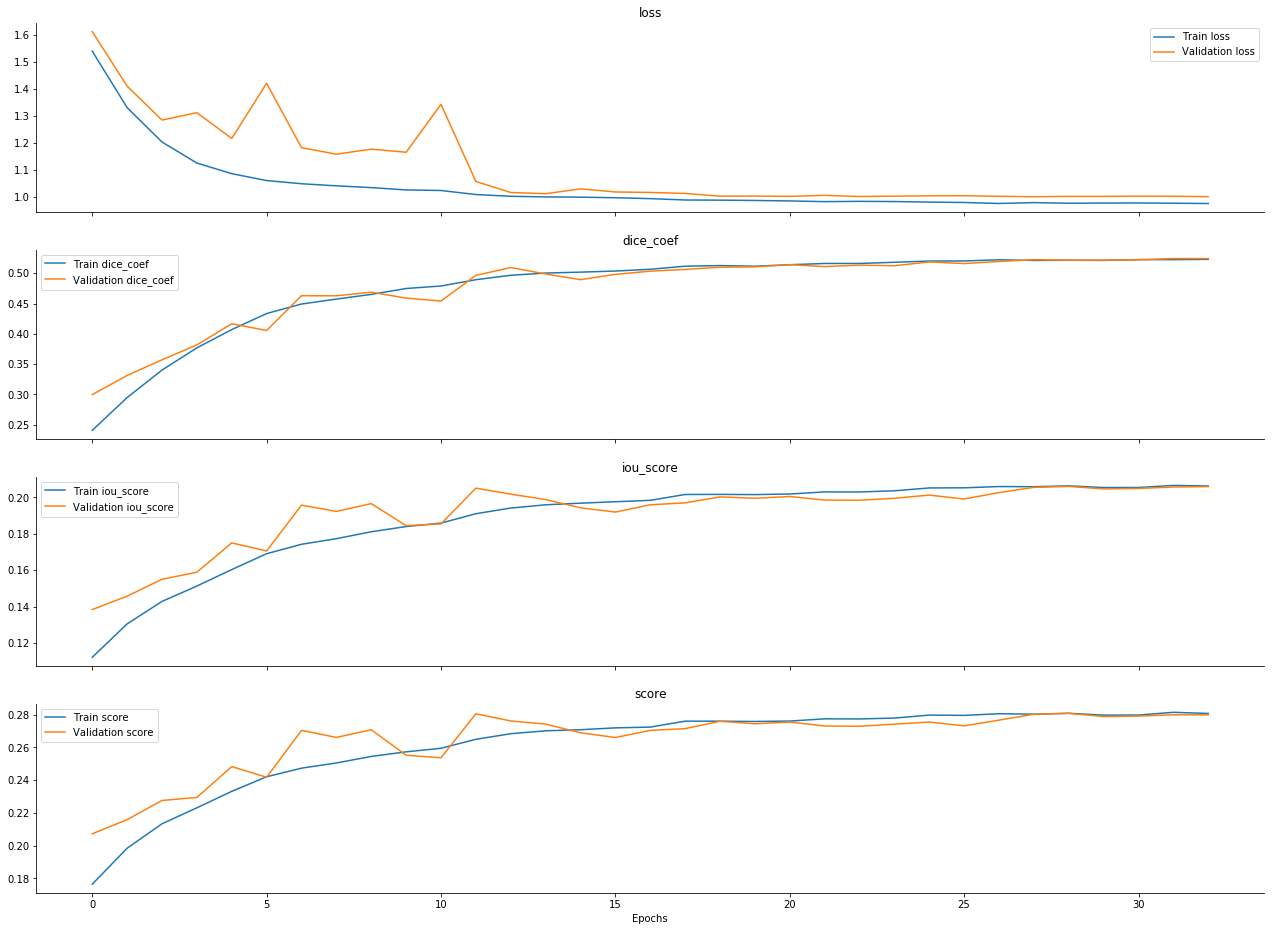

In [10]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

# Fold 1

Epoch 1/50
46/46 [==============================] - 588s 13s/step - loss: 1.5432 - dice_coef: 0.2466 - iou_score: 0.1162 - score: 0.1817 - val_loss: 1.5154 - val_dice_coef: 0.3055 - val_iou_score: 0.1475 - val_score: 0.2198
Epoch 2/50
46/46 [==============================] - 563s 12s/step - loss: 1.3390 - dice_coef: 0.2894 - iou_score: 0.1288 - score: 0.1970 - val_loss: 1.3403 - val_dice_coef: 0.3445 - val_iou_score: 0.1575 - val_score: 0.2300
Epoch 3/50
46/46 [==============================] - 574s 12s/step - loss: 1.2375 - dice_coef: 0.3249 - iou_score: 0.1395 - score: 0.2097 - val_loss: 1.2536 - val_dice_coef: 0.3513 - val_iou_score: 0.1552 - val_score: 0.2283
Epoch 4/50
46/46 [==============================] - 573s 12s/step - loss: 1.1552 - dice_coef: 0.3684 - iou_score: 0.1528 - score: 0.2248 - val_loss: 1.2297 - val_dice_coef: 0.3872 - val_iou_score: 0.1688 - val_score: 0.2426
Epoch 5/50
46/46 [==============================] - 574s 12s/step - loss: 1.0980 - dice_coef: 0.4074 - i

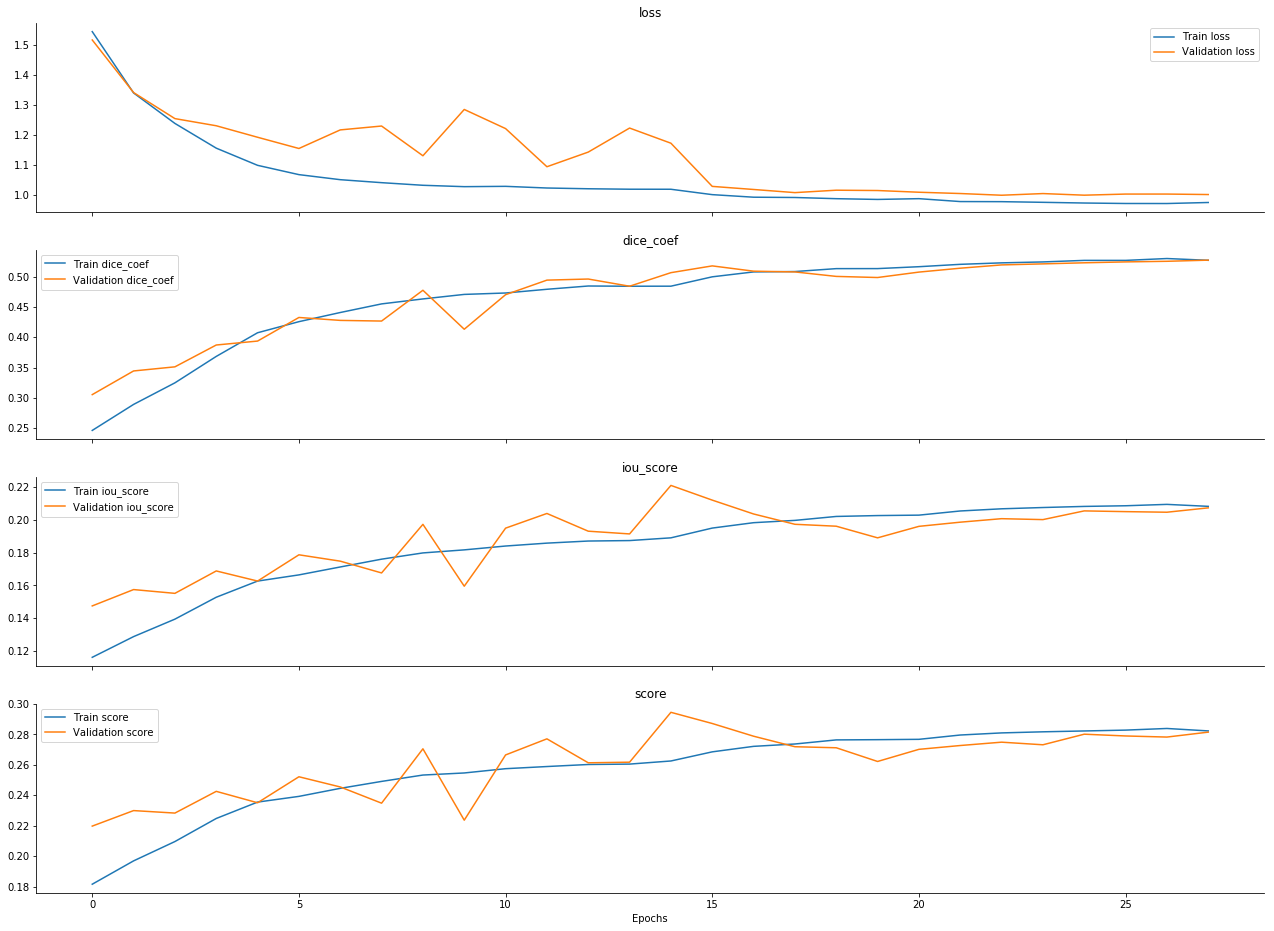

In [11]:
X_train = kfold_set[kfold_set['fold_1'] == 'train']
X_val = kfold_set[kfold_set['fold_1'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_1_path, monitor='val_loss', mode='min', save_best_only=True)

callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

# Fold 2

Epoch 1/50
46/46 [==============================] - 590s 13s/step - loss: 1.4412 - dice_coef: 0.2541 - iou_score: 0.1159 - score: 0.1816 - val_loss: 1.6871 - val_dice_coef: 0.3242 - val_iou_score: 0.1318 - val_score: 0.1953
Epoch 2/50
46/46 [==============================] - 561s 12s/step - loss: 1.2466 - dice_coef: 0.3174 - iou_score: 0.1370 - score: 0.2072 - val_loss: 1.2713 - val_dice_coef: 0.3633 - val_iou_score: 0.1531 - val_score: 0.2239
Epoch 3/50
46/46 [==============================] - 575s 13s/step - loss: 1.1565 - dice_coef: 0.3561 - iou_score: 0.1484 - score: 0.2205 - val_loss: 1.2537 - val_dice_coef: 0.3761 - val_iou_score: 0.1558 - val_score: 0.2260
Epoch 4/50
46/46 [==============================] - 574s 12s/step - loss: 1.1023 - dice_coef: 0.3932 - iou_score: 0.1582 - score: 0.2309 - val_loss: 1.2152 - val_dice_coef: 0.4070 - val_iou_score: 0.1687 - val_score: 0.2397
Epoch 5/50
46/46 [==============================] - 574s 12s/step - loss: 1.0683 - dice_coef: 0.4229 - i

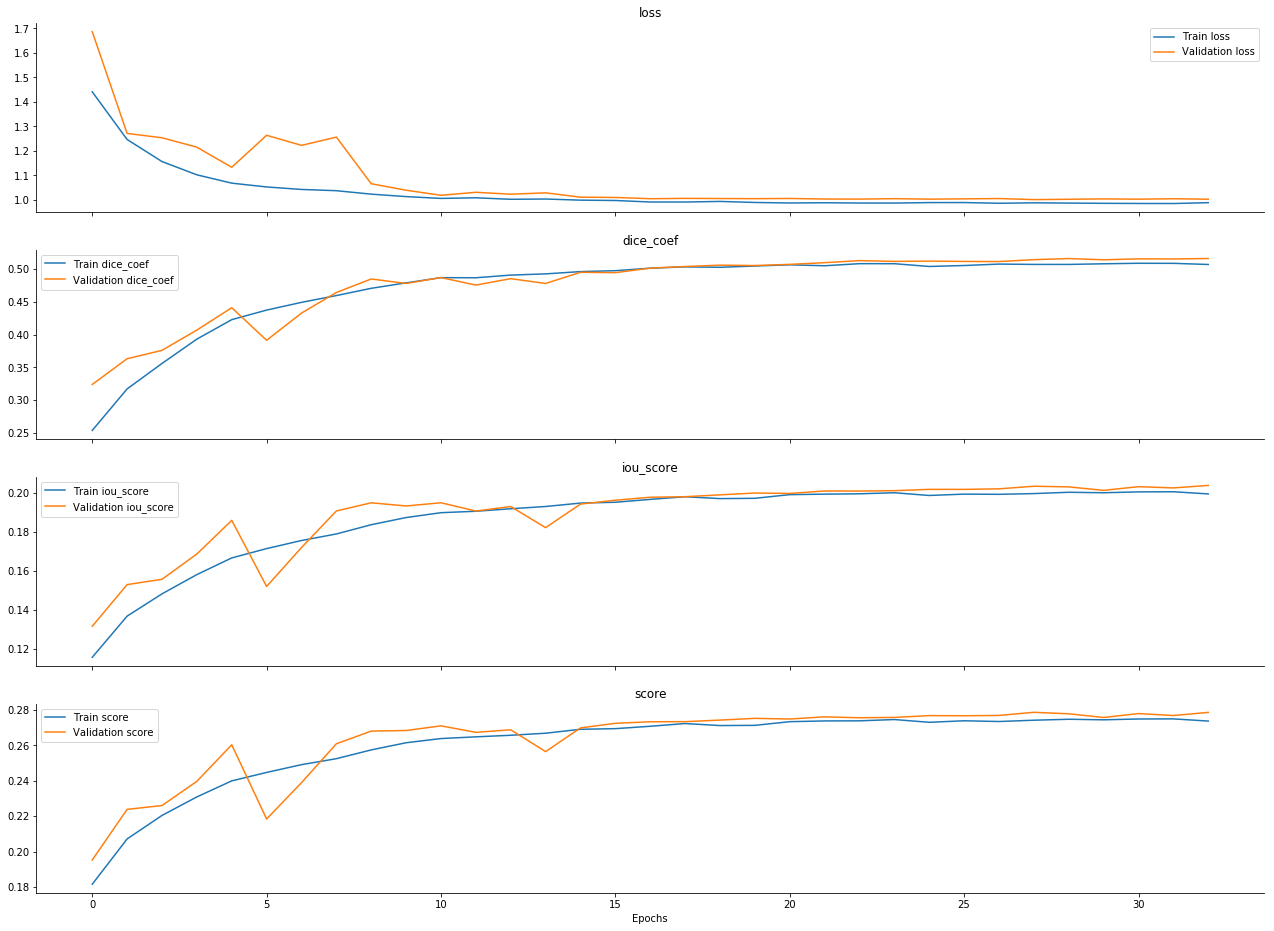

In [12]:
X_train = kfold_set[kfold_set['fold_2'] == 'train']
X_val = kfold_set[kfold_set['fold_2'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_2_path, monitor='val_loss', mode='min', save_best_only=True)

callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

In [13]:
# Fold 3

Epoch 1/50
46/46 [==============================] - 592s 13s/step - loss: 1.5272 - dice_coef: 0.2494 - iou_score: 0.1164 - score: 0.1812 - val_loss: 2.1449 - val_dice_coef: 0.2873 - val_iou_score: 0.1281 - val_score: 0.1953
Epoch 2/50
46/46 [==============================] - 561s 12s/step - loss: 1.3242 - dice_coef: 0.2867 - iou_score: 0.1267 - score: 0.1942 - val_loss: 1.4247 - val_dice_coef: 0.3146 - val_iou_score: 0.1407 - val_score: 0.2104
Epoch 3/50
46/46 [==============================] - 577s 13s/step - loss: 1.2305 - dice_coef: 0.3135 - iou_score: 0.1326 - score: 0.2014 - val_loss: 1.4345 - val_dice_coef: 0.2988 - val_iou_score: 0.1205 - val_score: 0.1827
Epoch 4/50
46/46 [==============================] - 577s 13s/step - loss: 1.1675 - dice_coef: 0.3426 - iou_score: 0.1412 - score: 0.2111 - val_loss: 1.2516 - val_dice_coef: 0.3206 - val_iou_score: 0.1364 - val_score: 0.2064
Epoch 5/50
46/46 [==============================] - 577s 13s/step - loss: 1.1079 - dice_coef: 0.3857 - i

46/46 [==============================] - 580s 13s/step - loss: 0.9646 - dice_coef: 0.5343 - iou_score: 0.2125 - score: 0.2867 - val_loss: 1.0009 - val_dice_coef: 0.5311 - val_iou_score: 0.2089 - val_score: 0.2826
Epoch 37/50
46/46 [==============================] - 580s 13s/step - loss: 0.9637 - dice_coef: 0.5360 - iou_score: 0.2125 - score: 0.2869 - val_loss: 0.9999 - val_dice_coef: 0.5315 - val_iou_score: 0.2099 - val_score: 0.2840
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping


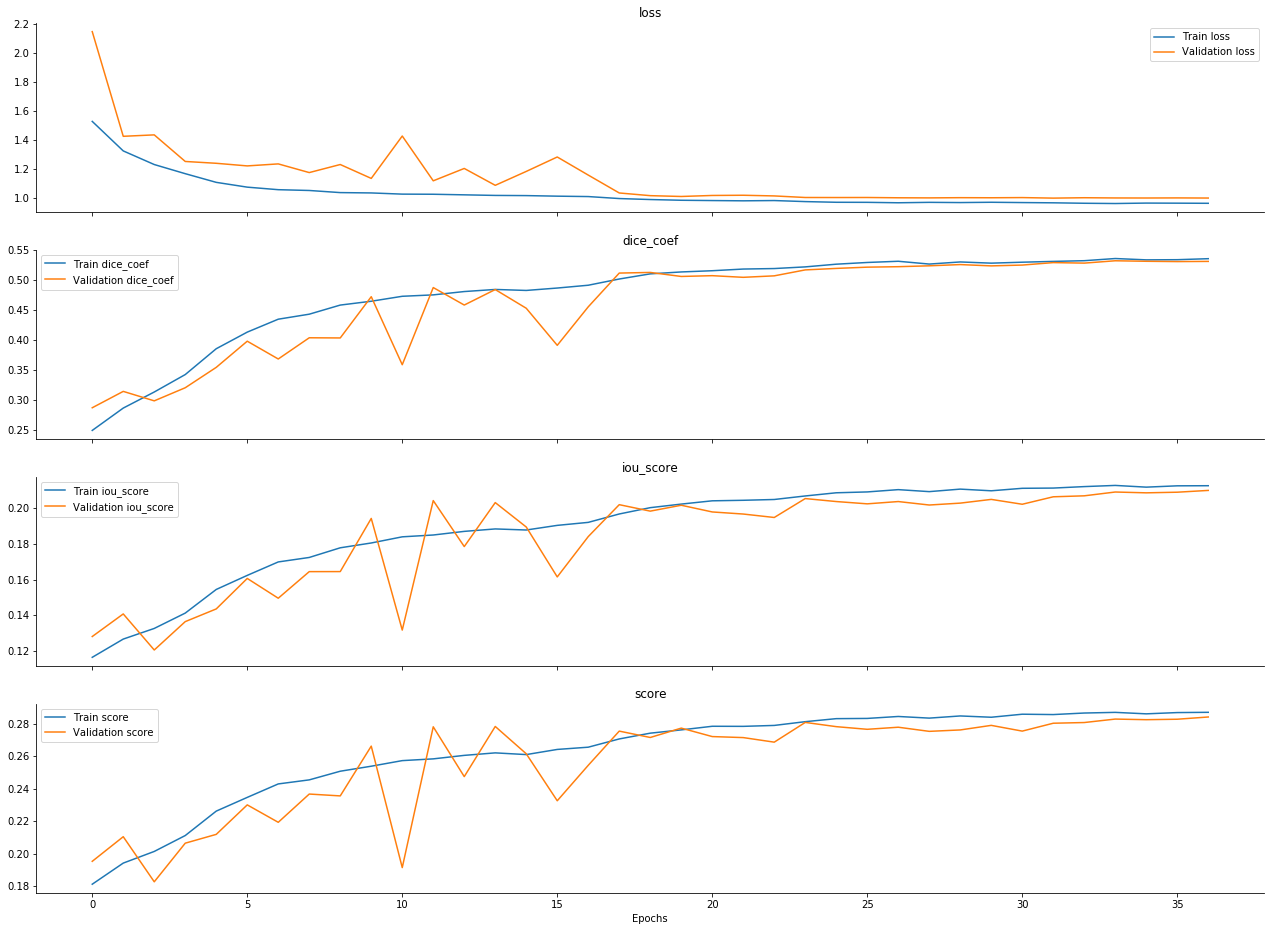

In [14]:
X_train = kfold_set[kfold_set['fold_3'] == 'train']
X_val = kfold_set[kfold_set['fold_3'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_3_path, monitor='val_loss', mode='min', save_best_only=True)

callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

# Fold 4

Epoch 1/50
46/46 [==============================] - 595s 13s/step - loss: 1.5394 - dice_coef: 0.2405 - iou_score: 0.1122 - score: 0.1765 - val_loss: 1.5999 - val_dice_coef: 0.2999 - val_iou_score: 0.1387 - val_score: 0.2077
Epoch 2/50
46/46 [==============================] - 559s 12s/step - loss: 1.3305 - dice_coef: 0.2944 - iou_score: 0.1304 - score: 0.1983 - val_loss: 1.4048 - val_dice_coef: 0.3311 - val_iou_score: 0.1457 - val_score: 0.2158
Epoch 3/50
46/46 [==============================] - 578s 13s/step - loss: 1.2031 - dice_coef: 0.3399 - iou_score: 0.1429 - score: 0.2134 - val_loss: 1.2734 - val_dice_coef: 0.3581 - val_iou_score: 0.1554 - val_score: 0.2280
Epoch 4/50
46/46 [==============================] - 582s 13s/step - loss: 1.1253 - dice_coef: 0.3765 - iou_score: 0.1512 - score: 0.2229 - val_loss: 1.2973 - val_dice_coef: 0.3846 - val_iou_score: 0.1602 - val_score: 0.2306
Epoch 5/50
46/46 [==============================] - 585s 13s/step - loss: 1.0868 - dice_coef: 0.4059 - i

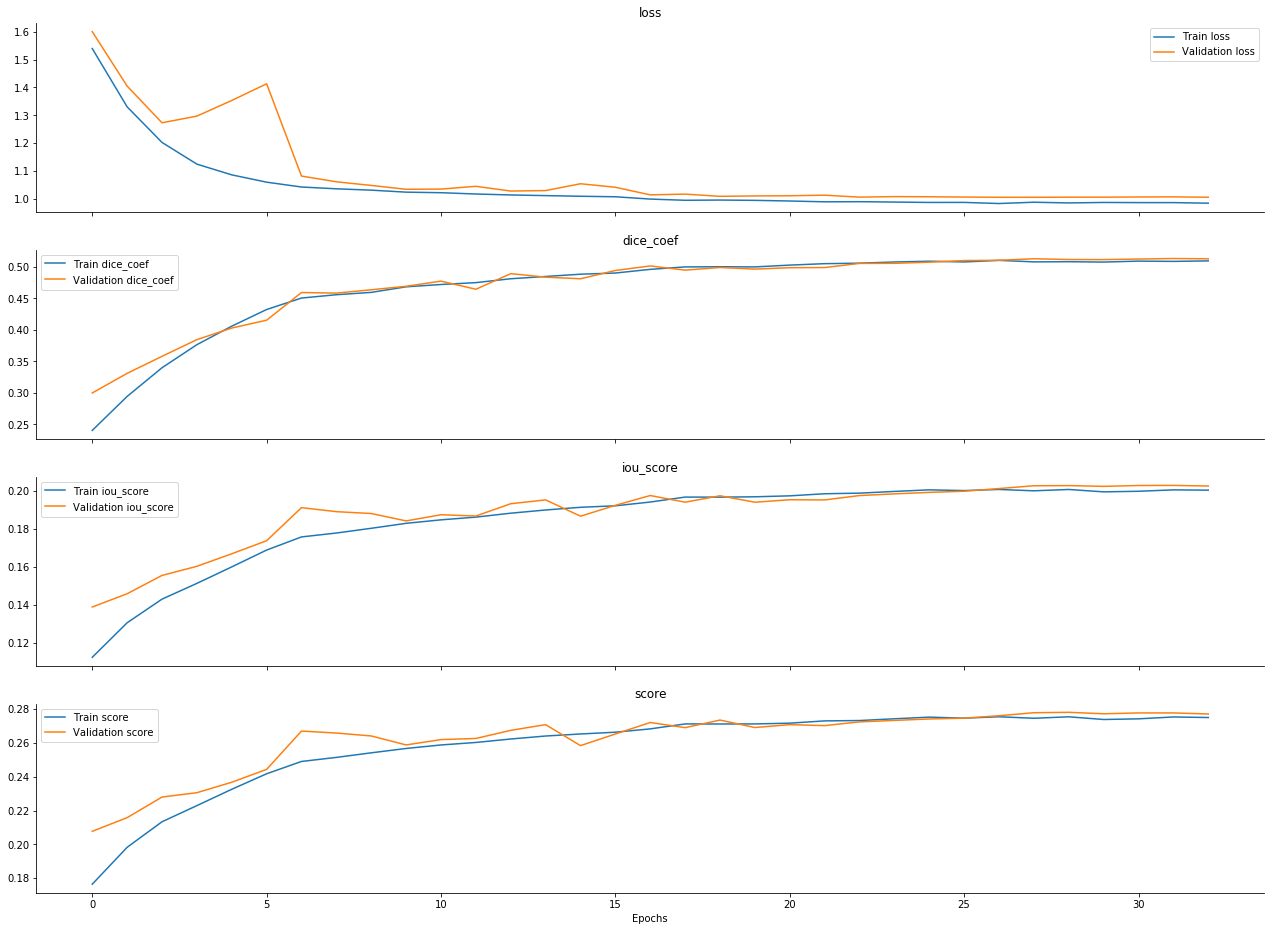

In [25]:
X_train = kfold_set[kfold_set['fold_4'] == 'train']
X_val = kfold_set[kfold_set['fold_4'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_4_path, monitor='val_loss', mode='min', save_best_only=True)

callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history

plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])